In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader ,random_split
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import FileUpload

**Data-Preprocessing**

In [2]:
# Defining transformations for the training and test datasets
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((28, 28)),  # Resize images to 28x28 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load the entire dataset
data_dir = '/kaggle/input/ocr-dataset/dataset'  # Replace with your dataset directory
full_dataset = ImageFolder(data_dir, transform=transform)

# Spliting the dataset into training and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



**Model Defination**

In [3]:
# Defining the CNN model
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 62)  # 62 classes for digits + uppercase + lowercase

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Initializing the model, loss function, and optimizer
model = OCRModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Model Training**

In [5]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calculate and print loss and accuracy for the current epoch
    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%')

Epoch [1/10], Loss: 0.7885, Training Accuracy: 80.25%
Epoch [2/10], Loss: 0.4322, Training Accuracy: 88.14%
Epoch [3/10], Loss: 0.3643, Training Accuracy: 89.66%
Epoch [4/10], Loss: 0.3244, Training Accuracy: 90.59%
Epoch [5/10], Loss: 0.2950, Training Accuracy: 91.37%
Epoch [6/10], Loss: 0.2725, Training Accuracy: 91.84%
Epoch [7/10], Loss: 0.2546, Training Accuracy: 92.33%
Epoch [8/10], Loss: 0.2422, Training Accuracy: 92.59%
Epoch [9/10], Loss: 0.2276, Training Accuracy: 93.00%
Epoch [10/10], Loss: 0.2169, Training Accuracy: 93.36%


In [6]:
# Save the trained model
torch.save(model.state_dict(), 'ocr_model.pth')

**Model Evaluation**

In [7]:
# Evaluate the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test dataset: {accuracy:.2f}%')

Accuracy on test dataset: 90.81%


**load and predict character**

In [8]:
# Load the model
model = OCRModel()
model.load_state_dict(torch.load('ocr_model.pth'))
model.eval()

# Function to predict character from an image
def predict_character(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Run the image through the model
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        character = full_dataset.classes[predicted.item()]

    return character

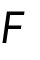

Predicted Character: F_U


In [9]:
# Define the path to the test image
test_image_path = '/kaggle/input/ocr-dataset/dataset/F_U/F_U_1001.png'  # Replace with the path to your image

# Display the test image
test_image = Image.open(test_image_path)
display(test_image)

# Predict the character
predicted_character = predict_character(test_image_path)
print(f'Predicted Character: {predicted_character}')